In [1]:
import os
import time
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout

Using TensorFlow backend.


## General

$L(x) = - \log{\frac{\sum_j p_j f_j(x)}{\sum_j p_j}}$

$f_i(x) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} e^{-\frac{(x-\mu_i)^2}{2\sigma_i^2}}$

:$\frac{\partial L(x)}{\partial f_i(x)} = -\frac{p_i}{\sum_j p_j f_j(x)}$

## alpha - mu

:$\frac{\partial L(x)}{\partial \alpha_i} = \frac{\partial L(x)}{\partial f_i(x)} \frac{\partial f_i(x)}{\partial \mu_i} \frac{\partial \mu_i}{\partial \alpha_i}$

$\frac{\partial f_i(x)}{\partial \mu_i} = \frac{x - \mu_i}{\sigma_i^3 \sqrt{2 \pi}} e^{-\frac{(x-\mu_i)^2}{2\sigma_i^2}}$

$\frac{\partial f_i(x)}{\partial \mu_i} = \frac{1}{\sqrt{2 \pi \sigma_i^2}} \frac{x - \mu_i}{\sigma_i^2} e^{-\frac{(x-\mu_i)^2}{2\sigma_i^2}}$

:$\frac{\partial f_i(x)}{\partial \mu_i} = \frac{x - \mu_i}{\sigma_i^2} f_i(x)$

$\mu_i = \text{sigmoid}(\alpha_i) (\mu_{max} - \mu_{min}) + \mu_{min}$

:$\frac{\partial \mu_i}{\partial \alpha_i} = \frac{e^{-\alpha_i}}{(e^{-\alpha_i} + 1)^2} (\mu_{max} - \mu_{min})$

## beta - sigma

:$\frac{\partial L(x)}{\partial \beta_i} = \frac{\partial L(x)}{\partial f_i(x)} \frac{\partial f_i(x)}{\partial \sigma_i} \frac{\partial \sigma_i}{\partial \beta_i}$

$\frac{\partial f_i(x)}{\partial \sigma_i} = \frac{(x - \mu_i)^2 - \sigma^2}{\sqrt{2 \pi} \sigma^4}e^{\frac{(x - \mu_i)^2}{2\sigma^2}}$

:$\frac{\partial f_i(x)}{\partial \sigma_i} = \frac{(x - \mu_i)^2 - \sigma^2}{\sigma^3} f_i(x)$

$\sigma_i = \text{sigmoid}(\beta_i) (\sigma_{max} - \sigma_{min}) + \sigma_{min}$

:$\frac{\partial \sigma_i}{\partial \beta_i} = \frac{e^{-\beta_i}}{(e^{-\beta_i} + 1)^2} (\sigma_{max} - \sigma_{min})$

## gamma - p

:$\frac{\partial L(x)}{\partial \gamma_i} = \frac{\partial L(x)}{\partial p_i} \frac{\partial p_i}{\partial \gamma_i}$

$\frac{\partial L(x)}{\partial p_i} = -\frac{\frac{f_i(x) \sum_{k \neq i} p_k}{(\sum_j p_j)^2} - \frac{\sum_{k \neq i} p_k f_k(x)}{\sum_j p_j}}{\sum_j p_j f_j(x) / \sum_j p_j}$

$\frac{\partial L(x)}{\partial p_i} = -\frac{f_i(x) \sum_{k \neq i} p_k - \sum_j p_j \sum_{k \neq i} p_k f_k(x)}{\sum_j p_j \sum_j p_j f_j(x)}$

Assuming $\sum_j p_j = 1$:

$\frac{\partial L(x)}{\partial p_i} = \frac{- f_i(x) (1 - p_j) + \sum_{k \neq i} p_k f_k(x)}{\sum_j p_j f_j(x)}$

$\frac{\partial L(x)}{\partial p_i} = \frac{-f_i(x) + \sum_{j} p_j f_j(x)}{\sum_j p_j f_j(x)}$

$p_i = \text{sigmoid}(\gamma_i) (p_{max} - p_{min}) + p_{min}$

:$\frac{\partial p_i}{\partial \gamma_i} = \frac{e^{-\gamma_i}}{(e^{-\gamma_i} + 1)^2} (p_{max} - p_{min})$

:::$\frac{\partial L(x)}{\partial \gamma_i} = \frac{- f_i(x) (1 - p_j) + \sum_{k \neq i} p_k f_k(x)}{f_j(x)} \frac{e^{-\gamma_i}}{(e^{-\gamma_i} + 1)^2} (p_{max} - p_{min})$

# Data Processing

In [2]:
files = os.listdir('data/good_zipcodes')
filename = '91108.csv'#np.random.choice(files)
df = pd.read_csv('data/good_zipcodes/' + filename)

df.TotalLandImpValue[df.TotalLandImpValue < 1] = 1

normalizer = df.TotalLandImpValue.mean()
df.TotalLandImpValue /= normalizer

C:\Users\Aaron\Anaconda3\envs\cs141\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [3]:
def pdf(x, mu, sig):
    return np.exp(-(x-mu)**2/(2*sig**2))/((2*np.pi)**.5*sig)

In [4]:
# Convert a parameter to its sigmoid representation.
def to_sigmoid(param, param_max, param_min):
    norm = (param - param_min) / (param_max - param_min)
    return np.log(norm / (1 - norm))

# Convert a sigmoid representation to a parameter.
def from_sigmoid(param, param_max, param_min):
    return 1 / (1 + np.exp(-param)) * (param_max - param_min) + param_min

In [5]:
def update(x, mu, sig, p,
           eta_p=1e-1, eta_mu=1e-1, eta_sig=1e-1,
           max_mu=1e2, min_mu=1e-2,
           max_sig=1e2, min_sig=1e-2,
           max_p=1e2, min_p=1e-2):
    
    # Apply logit to the input variables to get their sigmoid params.
    alpha = to_sigmoid(mu, max_mu, min_mu)
    beta = to_sigmoid(sig, max_sig, min_sig)
    gamma = to_sigmoid(p, max_p, min_p)
   
    # Calculate d Loss / d ProbabilityDensityFunction
    f = pdf(x, mu, sig)
    f_mean = np.sum(p * f, axis=1, keepdims=True)
    dL_df = - p / f_mean

    # Calculate d ProbabilityDensityFunction / d (parameter)
    df_dmu = (x - mu) / sig ** 2 * f
    df_dsig = ((x - mu) ** 2 - sig ** 2) / sig ** 3 * f
    
    # Calculate d (parameter) / d (logit(parameter))
    g = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2
    dmu_dalpha = g(alpha) * (max_mu - min_mu)
    dsig_dbeta = g(beta) * (max_sig - min_sig)
    dp_dgamma = g(gamma) * (max_p - min_p)
    
    # Calculate d Loss / d (parameter)
    dL_dp = (f_mean - f) / f_mean
    
    # Calculate d Loss / d (logit(parameter))
    dL_dalpha = dL_df * df_dmu * dmu_dalpha
    dL_dbeta = dL_df * df_dsig * dsig_dbeta
    dL_dgamma = dL_dp * dp_dgamma
    
    # Calculate logit(parameter)
    alpha -= eta_mu * np.mean(dL_dalpha, axis=0)
    beta -= eta_sig * np.mean(dL_dbeta, axis=0)
    gamma -= eta_p * np.mean(dL_dgamma, axis=0)
    
    # Calculate parameter
    new_mu = from_sigmoid(alpha, max_mu, min_mu)
    new_sig = from_sigmoid(beta, max_sig, min_sig)
    new_p = from_sigmoid(gamma, max_p, min_p)
    
    # Normalize the probabilities
    new_p = new_p / np.sum(new_p)
    
    return new_mu, new_sig, new_p

In [6]:
init_mu = np.array([150000, 330000]) / normalizer
init_sig = np.array([40000, 100000]) / normalizer
init_p = np.array([.6, .4])

In [7]:
def make_graph(mu, sig, p):
    x_plt = np.linspace(10e-3, np.max(df.TotalLandImpValue), 1000).reshape((1000, 1))
    y_plt = np.sum(p * pdf(x_plt, mu, sig), axis=1) / np.sum(p)

    plt.figure()
    plt.xlabel('Home Price ($)')
    plt.ylabel('Frequency')
    plt.plot(normalizer * x_plt, y_plt)
    hist, bins = np.histogram(normalizer * df.TotalLandImpValue)
    (normalizer * df.TotalLandImpValue).hist(bins=50, weights = 50 * np.ones_like(df.index) / len(df.index))
    plt.show()

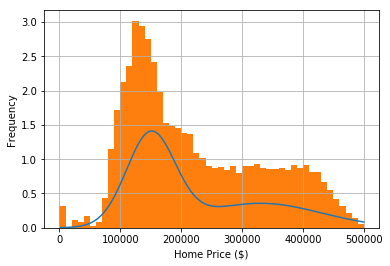

In [8]:
make_graph(init_mu, init_sig, init_p)

In [13]:
mu, sig, p = init_mu, init_sig, init_p
x = df.TotalLandImpValue.values
x = x.reshape((len(x), 1))

eps = 1e-8
eps_avg = 5
max_runs = int(1e5)

loss = np.empty(max_runs)
loss[:] = np.nan

hist = [np.array([mu, sig, p])]

for n in range(max_runs):
    mu, sig, p = update(x, mu, sig, p)
    
    loss[n] = np.mean(-np.log(np.sum(p * pdf(x, mu, sig), axis=1)))
    hist.append(np.array([mu, sig, p]))
    
    if n > eps_avg and \
       np.mean(np.log(loss[n-eps_avg:n]/loss[n-eps_avg+1:n+1])) < eps:
        break
        
loss = loss[np.logical_not(np.isnan(loss))]
print('Num runs:', len(hist) - 1)

Num runs: 1298


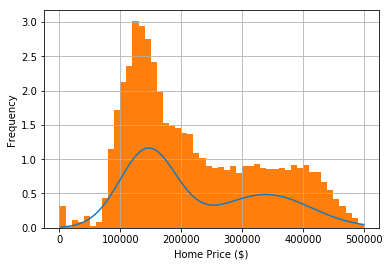

In [14]:
for i in np.linspace(0, len(hist) - 1, 25):
    mu, sig, p = hist[int(i)]
    make_graph(mu, sig, p)
    time.sleep(.1)
    clear_output(wait=True)

In [15]:
print('mu\t', init_mu, '\t', hist[-1][0])
print('sig\t', init_sig, '\t', hist[-1][1])
print('p\t', init_p, '\t', hist[-1][2])

mu	 [0.67037904 1.47483388] 	 [0.65095868 1.51168388]
sig	 [0.17876774 0.44691936] 	 [0.20706331 0.33354253]
p	 [0.6 0.4] 	 [0.59447885 0.40552115]


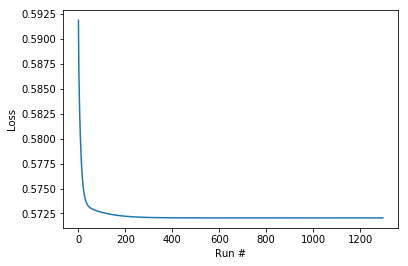

In [16]:
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Run #')
plt.ylabel('Loss')
plt.show()